In [1]:
# import the libraries 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
# Set the resolution of the plotted figures
plt.rcParams['figure.dpi'] = 200

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

In [3]:
# Read dataset
df = pd.read_csv('heart.csv')
df 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
# Display a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [6]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
# Get the summary statistics for categorical variables
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


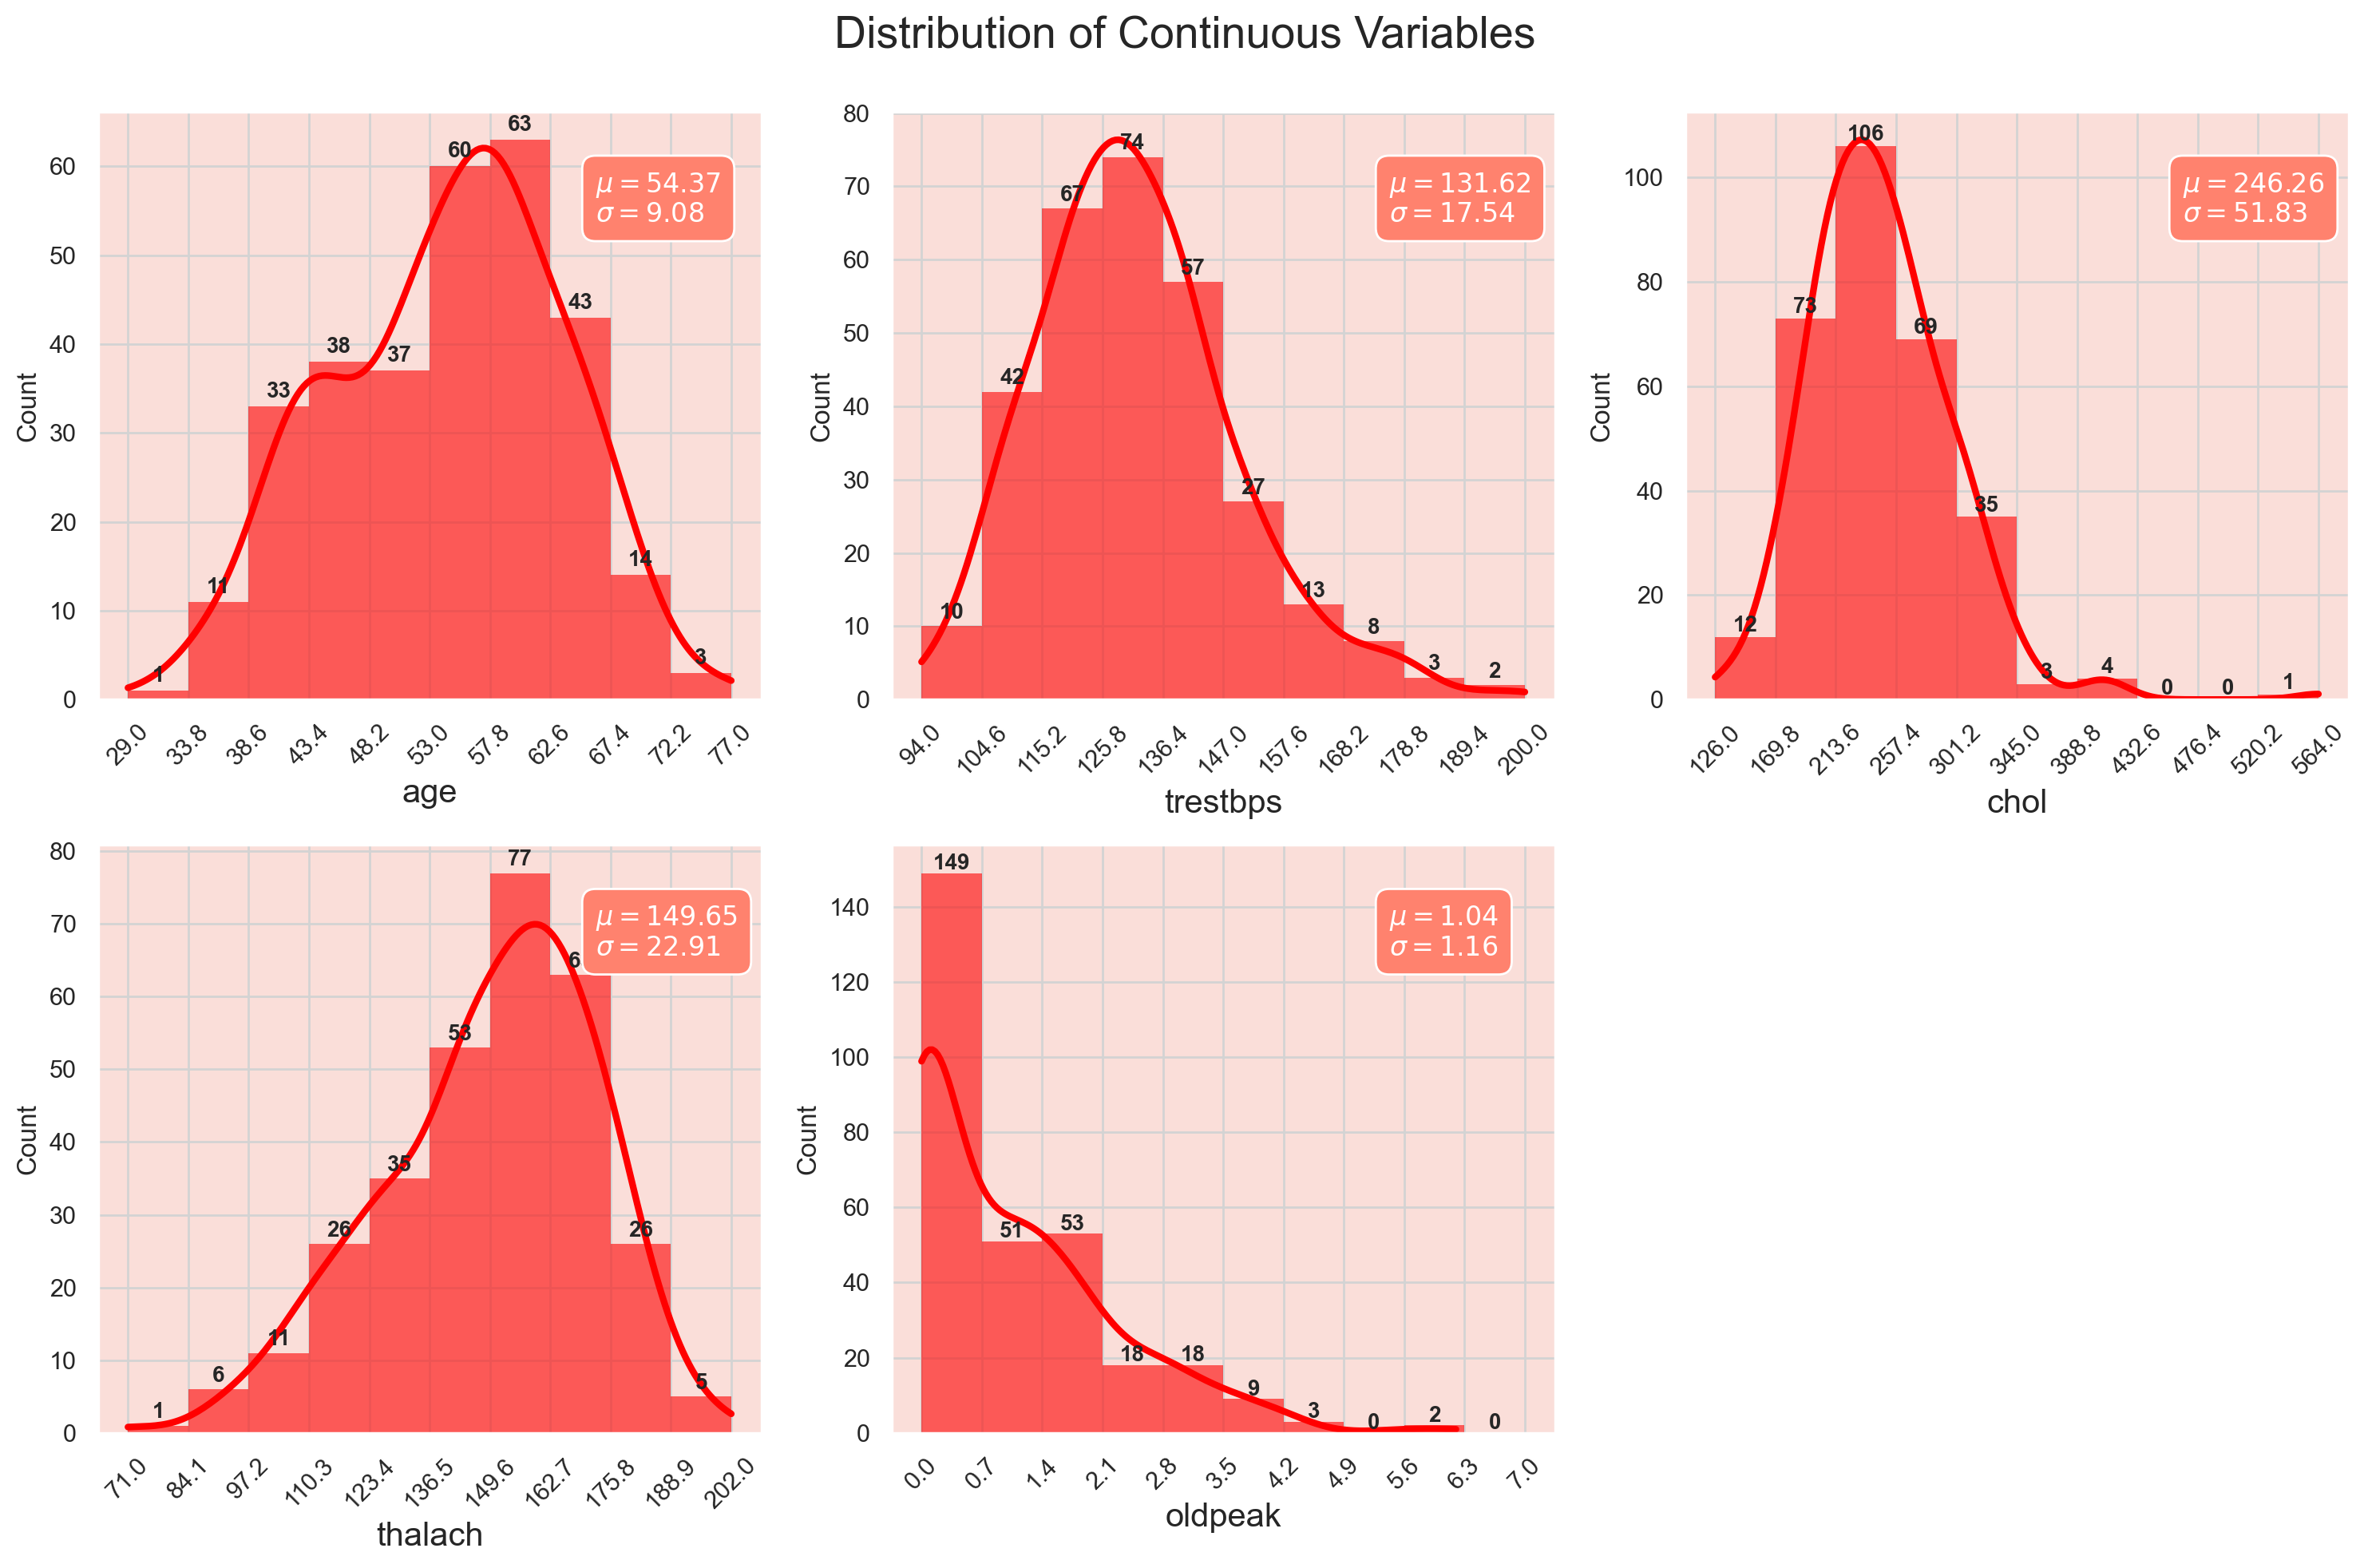

In [8]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [9]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

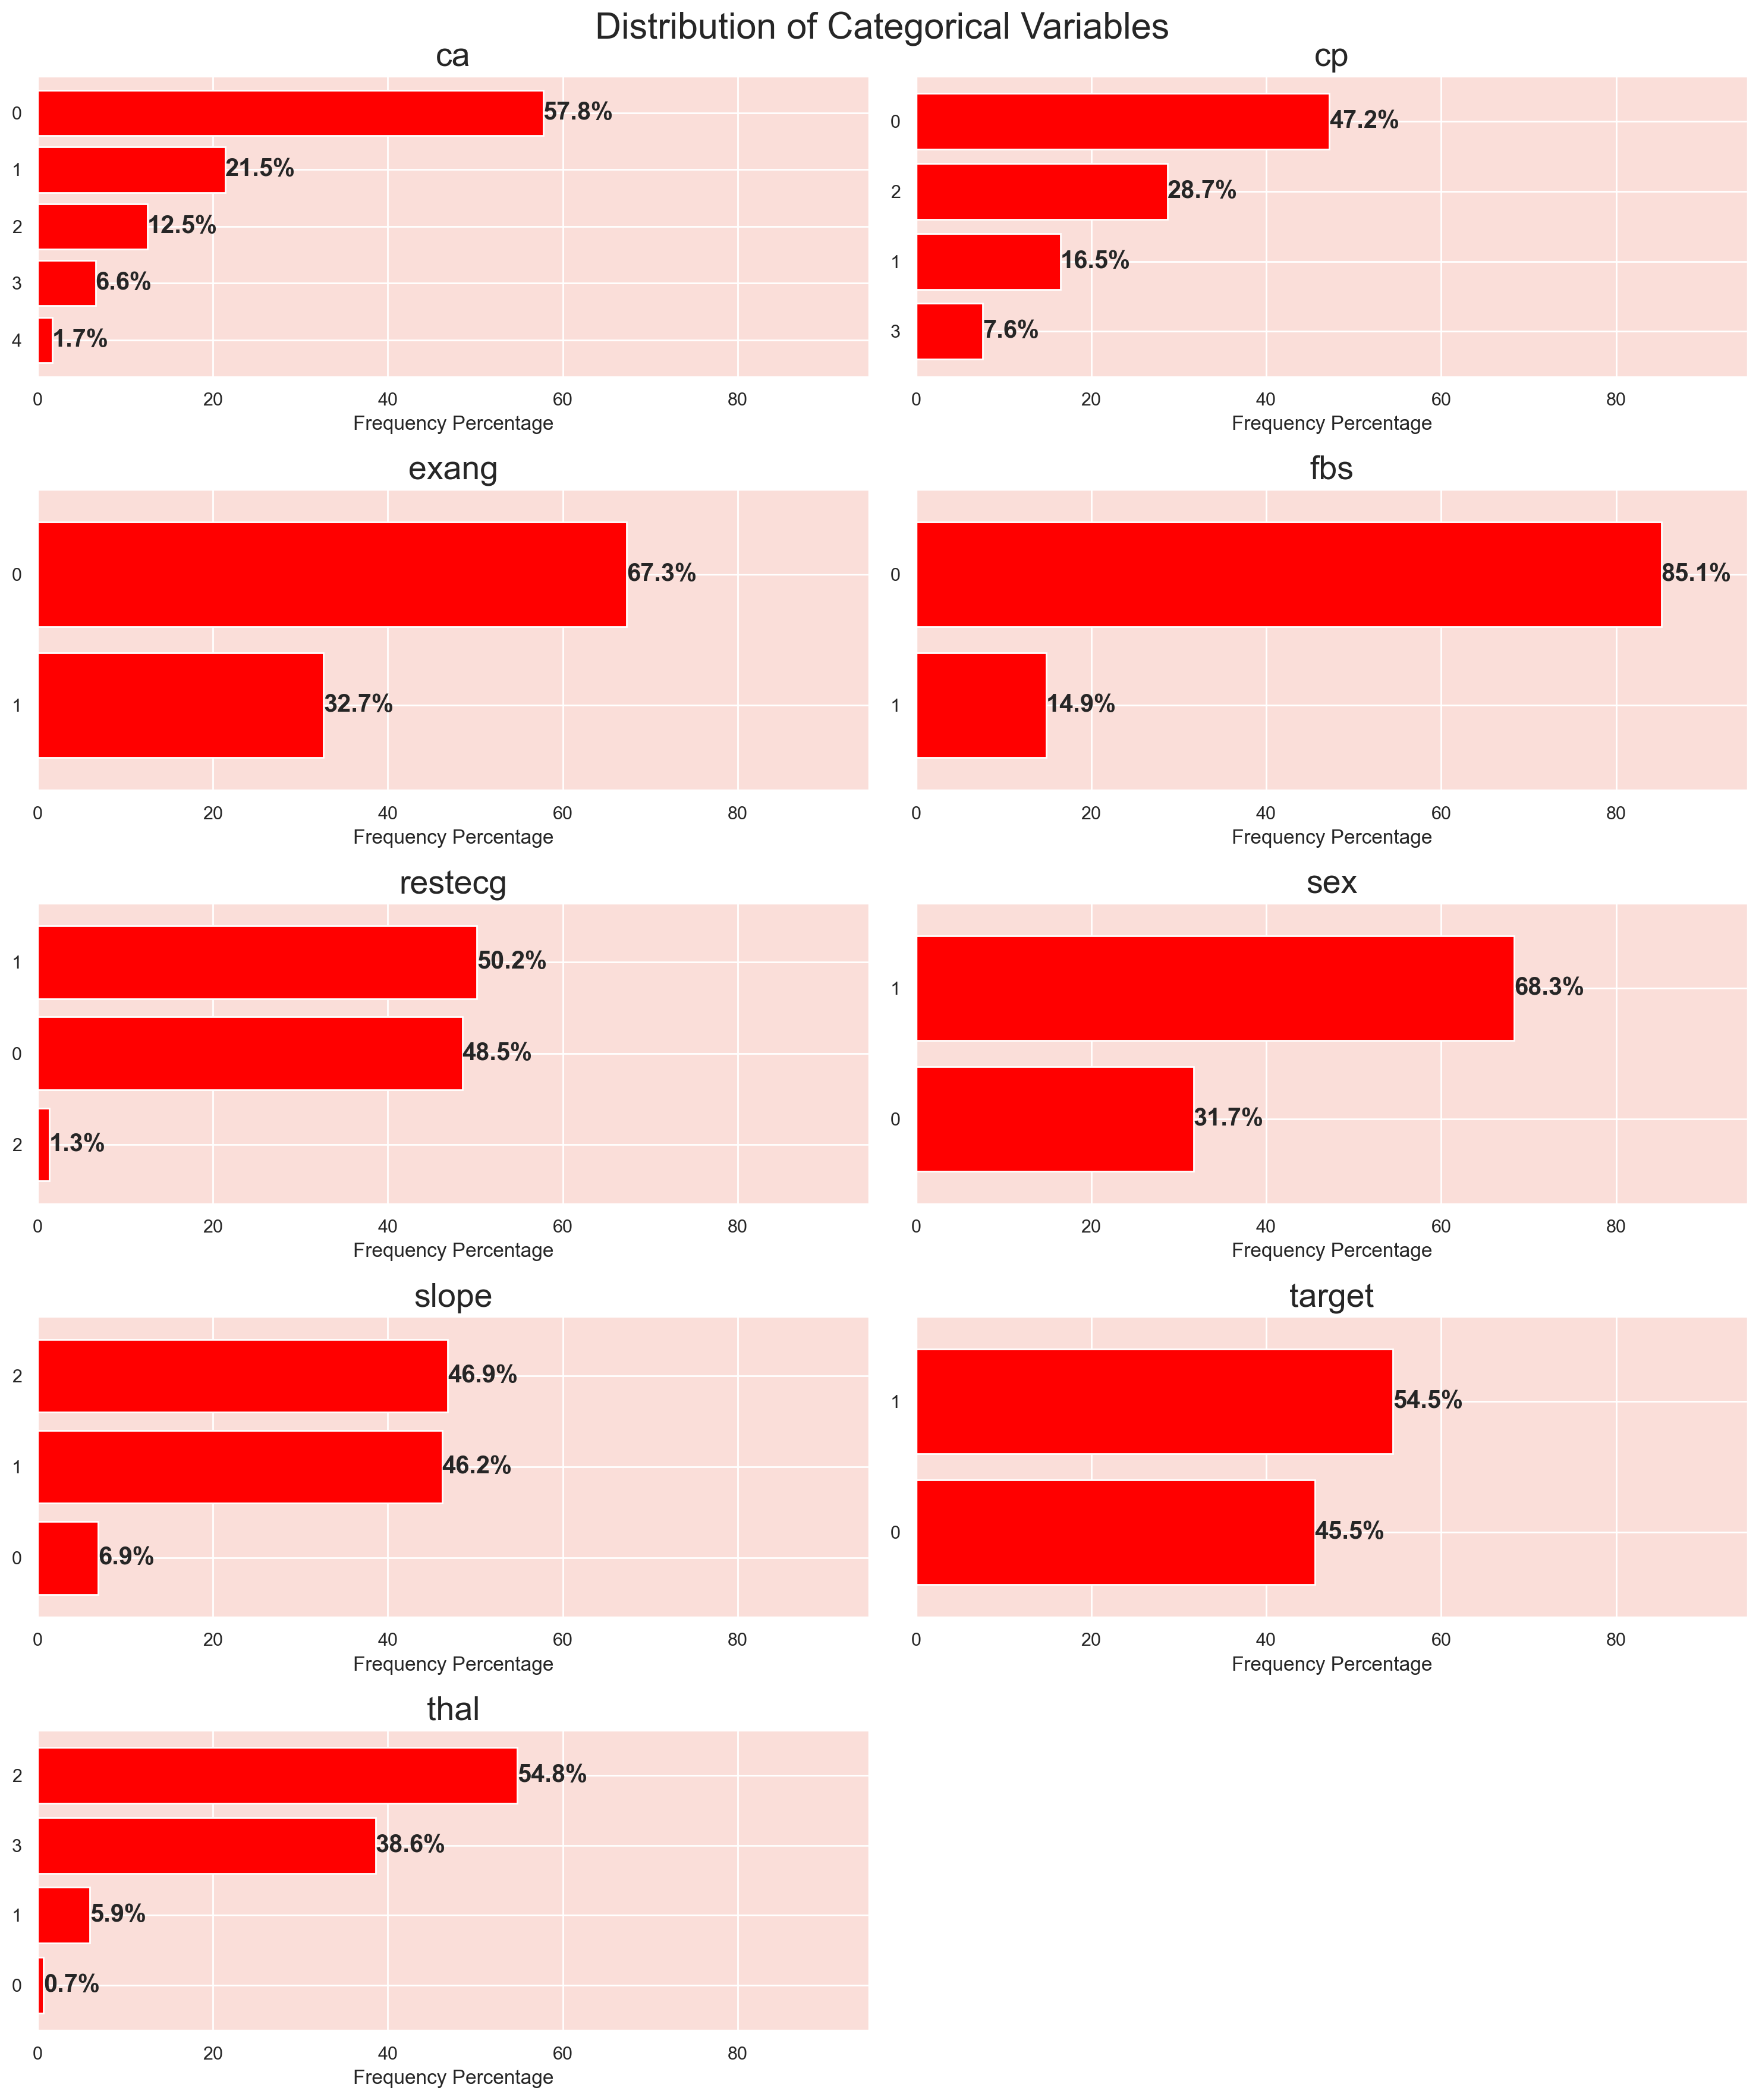

In [10]:
# Set up the subplot for a 4x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


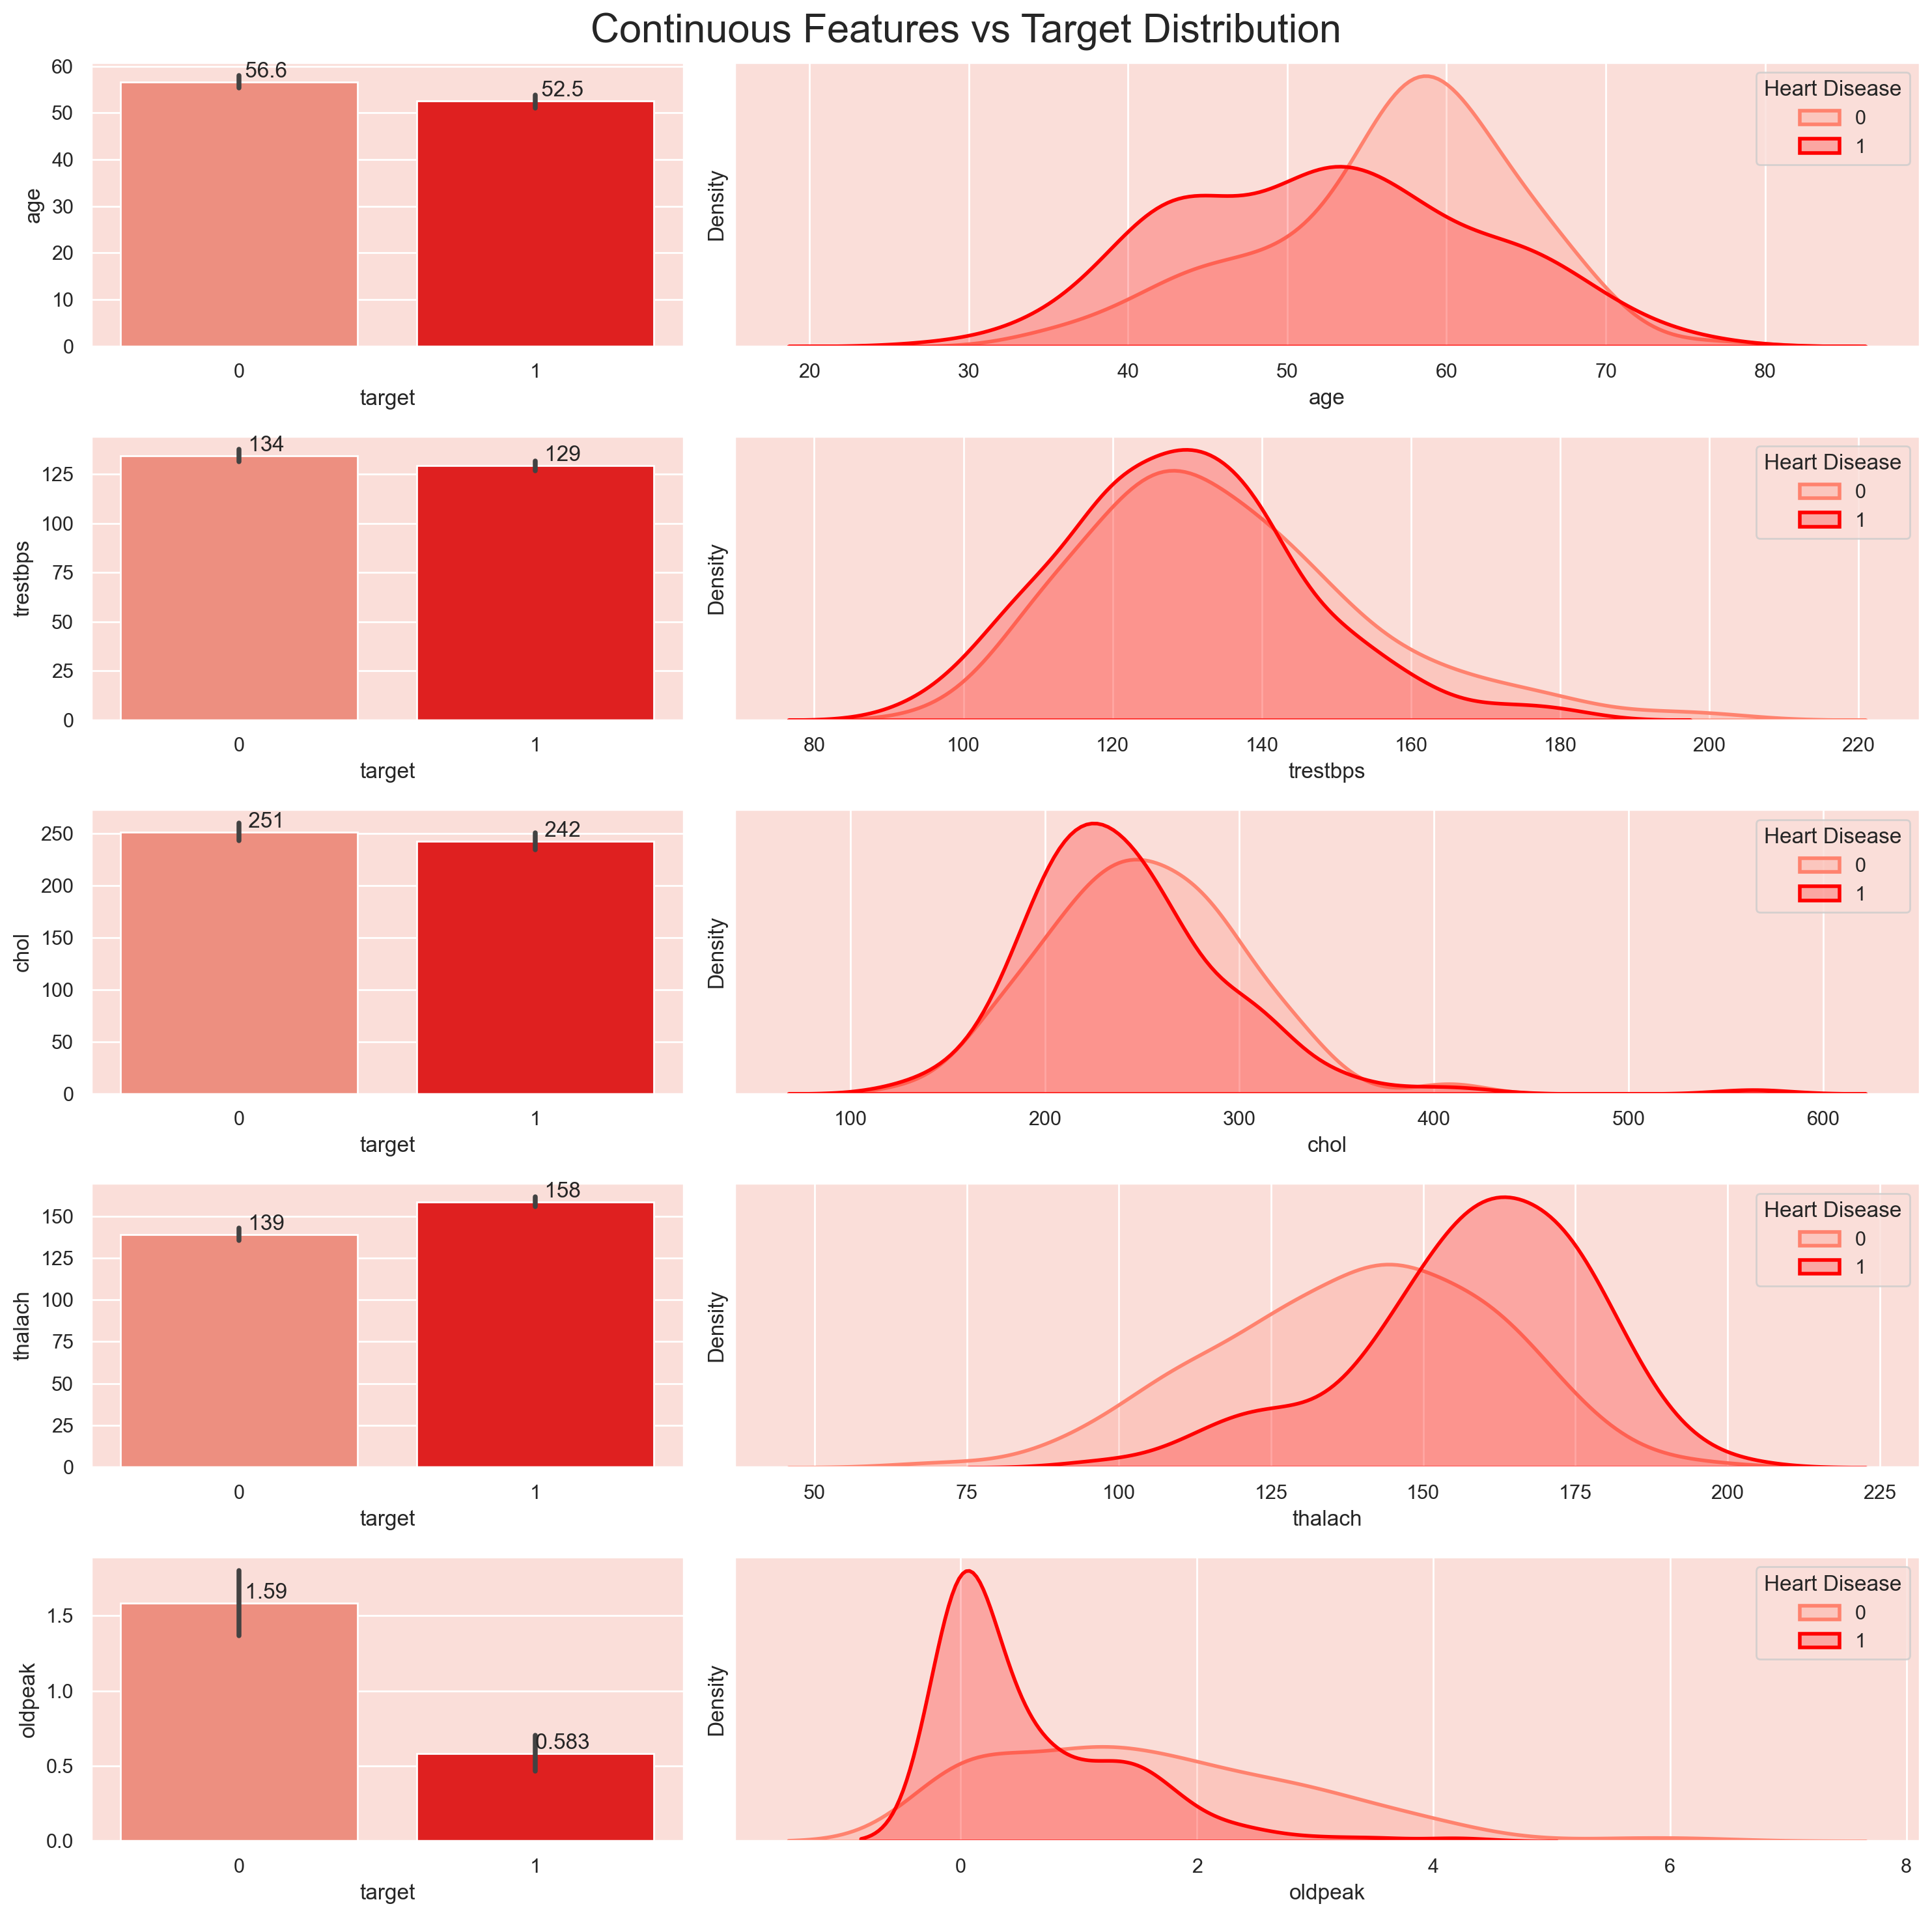

In [11]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

In [12]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

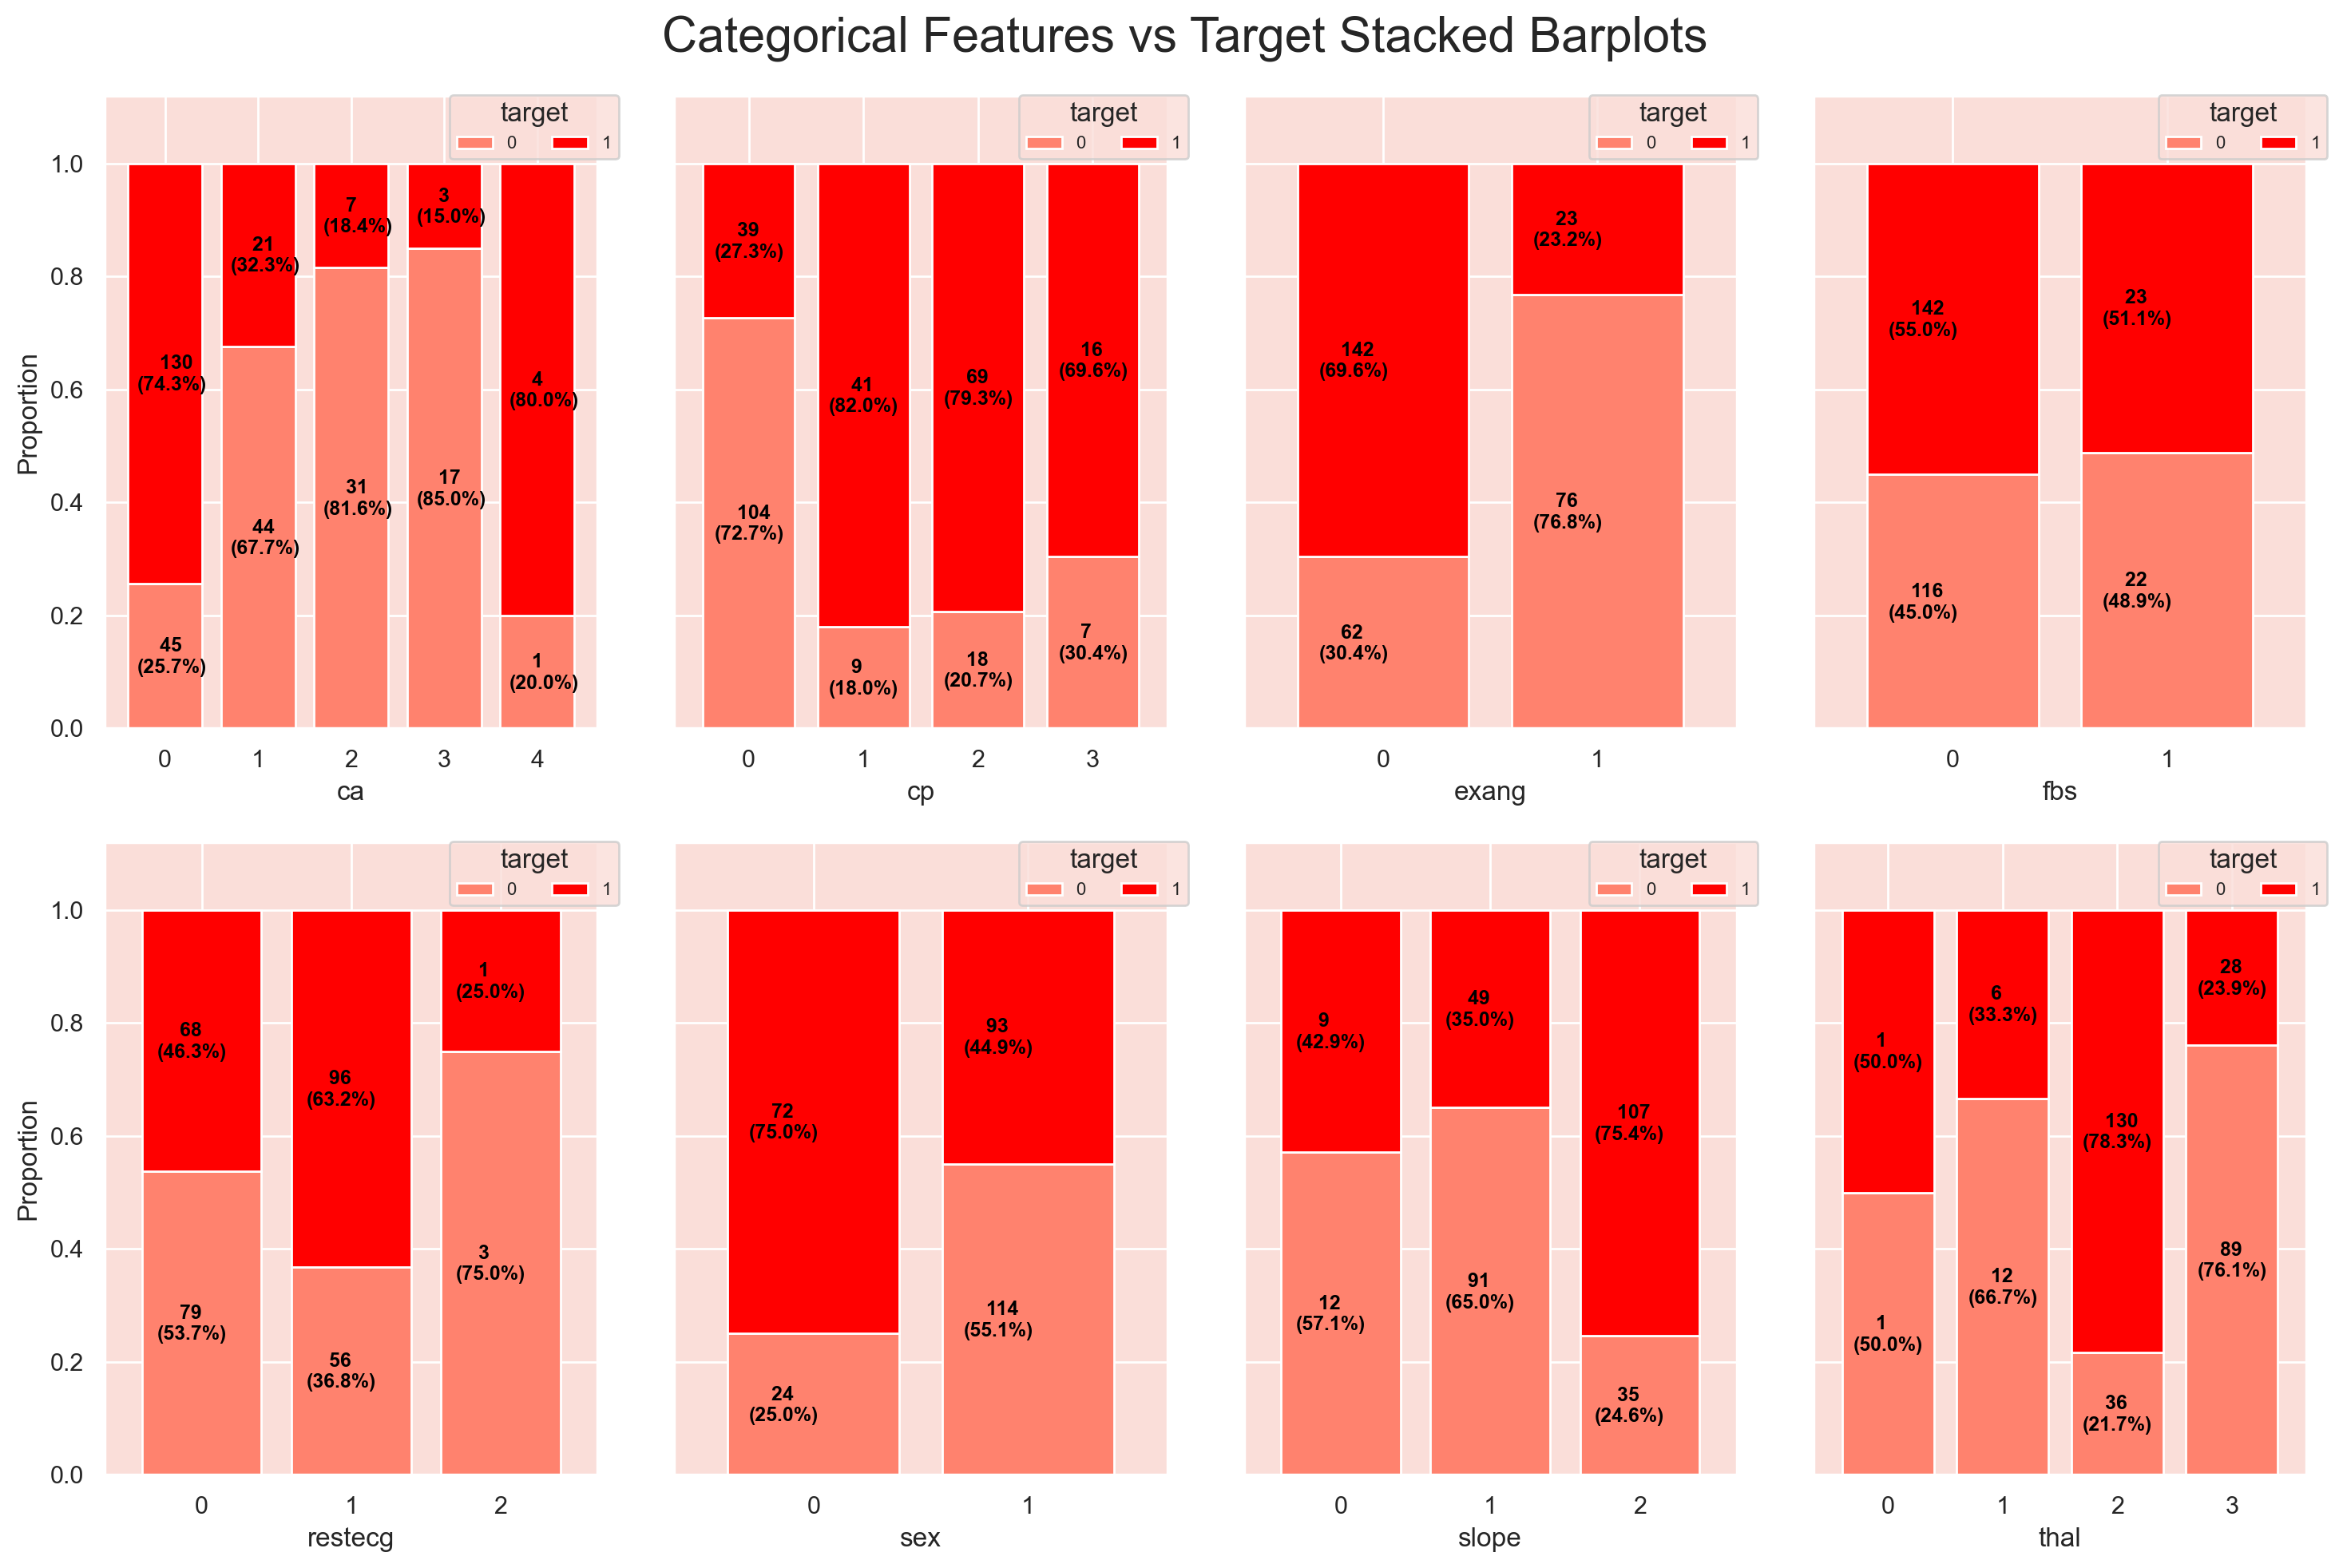

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

In [14]:
# Check for missing values in the dataset
df.isnull().sum().sum()

0

In [15]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [16]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

In [17]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1           uint8
cp_2           uint8
cp_3           uint8
restecg_1      uint8
restecg_2      uint8
thal_1         uint8
thal_2         uint8
thal_3         uint8
dtype: object

In [18]:
# Displaying the resulting DataFrame after one-hot encoding
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0


In [19]:
# Define the features (X) and the output labels (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [20]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [21]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,56,1,130,283,1,103,1,1.6,0,0,0,0,0,0,0,0,0,1
191,58,1,128,216,0,131,1,2.2,1,3,0,0,0,0,0,0,0,1
15,50,0,120,219,0,158,0,1.6,1,0,0,1,0,1,0,0,1,0
224,54,1,110,239,0,126,1,2.8,1,1,0,0,0,1,0,0,0,1
250,51,1,140,298,0,122,1,4.2,1,3,0,0,0,1,0,0,0,1


# MODEL BUILDING

# DECISION TREE

In [22]:
#decision tree
dt_base = DecisionTreeClassifier(random_state=0)

In [23]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest recall for class 1 is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [24]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [25]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [26]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [27]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [28]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [29]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    # Convert dictionary to dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

In [30]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.8,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79


# SVM

In [31]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

In [32]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [33]:
# Call the function for hyperparameter tuning
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [34]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.55      1.00      0.71       132

    accuracy                           0.55       242
   macro avg       0.27      0.50      0.35       242
weighted avg       0.30      0.55      0.39       242



In [35]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.54      1.00      0.70        33

    accuracy                           0.54        61
   macro avg       0.27      0.50      0.35        61
weighted avg       0.29      0.54      0.38        61



In [36]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.0,0.54,0.0,1.0,0.0,0.7,0.27,0.5,0.35,0.54


In [37]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0


In [38]:

filtered_df = df_encoded[df_encoded['target'] == 0]

# Display the filtered DataFrame
filtered_df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
165,67,1,160,286,0,108,1,1.5,1,3,0,0,0,0,0,0,0,1,0
166,67,1,120,229,0,129,1,2.6,1,2,0,0,0,0,0,0,0,0,1
167,62,0,140,268,0,160,0,3.6,0,2,0,0,0,0,0,0,0,1,0
168,63,1,130,254,0,147,0,1.4,1,1,0,0,0,0,0,0,0,0,1
169,53,1,140,203,1,155,1,3.1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,0,0,0,0,1,0,0,0,1
299,45,1,110,264,0,132,0,1.2,1,0,0,0,0,1,1,0,0,0,1
300,68,1,144,193,1,141,0,3.4,1,2,0,0,0,0,1,0,0,0,1
301,57,1,130,131,0,115,1,1.2,1,1,0,0,0,0,1,0,0,0,1


In [39]:
print(best_svm.predict([[67,1,160,286,0,108,1,1.5,1,3,0,0,0,0,0,0,1,0]]))

[1]


In [40]:
filtered_df = df_encoded[df_encoded['target'] == 1]

# Display the filtered DataFrame
filtered_df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,56,1,120,240,0,169,0,0.0,0,0,1,1,0,0,1,0,0,1,0
161,55,0,132,342,0,166,0,1.2,2,0,1,1,0,0,1,0,0,1,0
162,41,1,120,157,0,182,0,0.0,2,0,1,1,0,0,1,0,0,1,0
163,38,1,138,175,0,173,0,0.0,2,4,1,0,1,0,1,0,0,1,0


In [42]:
print(best_svm.predict([[63,1,145,233,1,150,0,2.3,0,0,0,0,1,0,0,1,0,0]]))

[1]


# KNN

In [43]:
#KNN
# Define the base KNN model and set up the pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [44]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [45]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'distance'}


In [46]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       132

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242



In [47]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [48]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


In [49]:
print(best_knn.predict([[67,1,160,286,0,108,1,1.5,1,3,0,0,0,0,0,0,1,0]]))

[0]


# Random Forest

In [50]:
rf_base = RandomForestClassifier(random_state=0)

In [51]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [52]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


In [53]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81       110
           1       0.83      0.87      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [54]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [55]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84


In [56]:
print(best_rf.predict([[63,1,145,233,1,150,0,2.3,0,0,0,0,1,0,0,1,0,0]]))

[0]


# Ensemble model

In [57]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Create a voting classifier with SVM and Random Forest
voting_clf = VotingClassifier(estimators=[('svm', best_svm), ('rf', best_rf)], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)



VotingClassifier(estimators=[('svm',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svm',
                                               SVC(C=0.0011, degree=2,
                                                   probability=True))])),
                             ('rf',
                              RandomForestClassifier(max_depth=2,
                                                     min_samples_leaf=3,
                                                     n_estimators=30,
                                                     random_state=0))],
                 voting='soft')

In [58]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, voting_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       110
           1       0.88      0.80      0.83       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [59]:
# Evaluate the ensemble on the test data
print(classification_report(y_test, voting_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        28
           1       0.87      0.82      0.84        33

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [60]:
voting_evaluation = evaluate_model(voting_clf, X_test, y_test, 'Voting classifier')
voting_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
Voting classifier,0.8,0.87,0.86,0.82,0.83,0.84,0.84,0.84,0.84,0.84


# CONCLUSION

In [61]:
# Concatenate the dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation,voting_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'macro_avg_precision'
results = results.sort_values(by='macro_avg_precision', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84
Voting classifier,0.80,0.87,0.86,0.82,0.83,0.84,0.84,0.84,0.84,0.84
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84
DT,0.80,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79
SVM,0.00,0.54,0.00,1.00,0.00,0.70,0.27,0.50,0.35,0.54


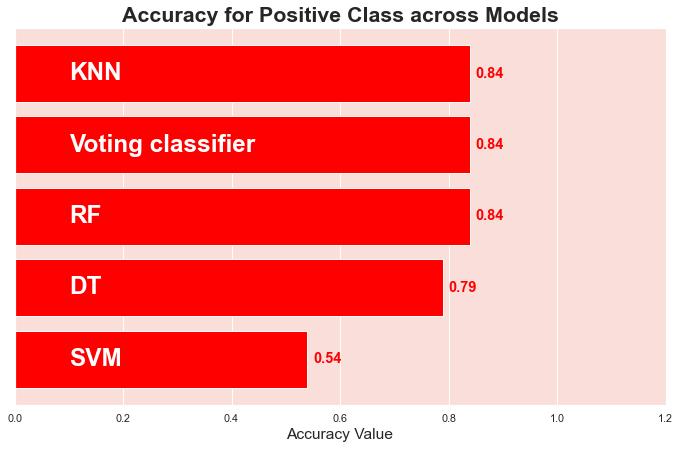

In [62]:
# Sort values based on 'accuracy'
results.sort_values(by='accuracy', ascending=True, inplace=True)
recall_1_scores = results['accuracy']

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, recall_1_scores, color='red')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0, 1.2])

# Add title and xlabel
plt.title("Accuracy for Positive Class across Models", fontweight='bold', fontsize=22)
plt.xlabel('Accuracy Value', fontsize=16)
plt.show()

# Pickle file

In [63]:
import pickle
pickle.dump(best_rf,open("model.pkl","wb"))

In [64]:
model= pickle.load(open("model.pkl","rb"))
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0


In [65]:
df_encoded.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'slope', 'ca', 'target', 'cp_1', 'cp_2', 'cp_3', 'restecg_1',
       'restecg_2', 'thal_1', 'thal_2', 'thal_3'],
      dtype='object')

In [66]:
unique_values_per_column = {}

for column in df_encoded.columns:
    unique_values_per_column[column] = df_encoded[column].unique()

# Print unique values for each column
for column, values in unique_values_per_column.items():
    print(f"Unique values for column '{column}': {values}")


Unique values for column 'age': [63 37 41 56 57 44 52 54 48 49 64 58 50 66 43 69 59 42 61 40 71 51 65 53
 46 45 39 47 62 34 35 29 55 60 67 68 74 76 70 38 77]
Unique values for column 'sex': [1 0]
Unique values for column 'trestbps': [145 130 120 140 172 150 110 135 160 105 125 142 155 104 138 128 108 134
 122 115 118 100 124  94 112 102 152 101 132 148 178 129 180 136 126 106
 156 170 146 117 200 165 174 192 144 123 154 114 164]
Unique values for column 'chol': [233 250 204 236 354 192 294 263 199 168 239 275 266 211 283 219 340 226
 247 234 243 302 212 175 417 197 198 177 273 213 304 232 269 360 308 245
 208 264 321 325 235 257 216 256 231 141 252 201 222 260 182 303 265 309
 186 203 183 220 209 258 227 261 221 205 240 318 298 564 277 214 248 255
 207 223 288 160 394 315 246 244 270 195 196 254 126 313 262 215 193 271
 268 267 210 295 306 178 242 180 228 149 278 253 342 157 286 229 284 224
 206 167 230 335 276 353 225 330 290 172 305 188 282 185 326 274 164 307
 249 341 407 217 174 28

In [67]:

min_max_values = {}

for column in df_encoded.columns:
    min_max_values[column] = {
        'min': df_encoded[column].min(),
        'max': df_encoded[column].max()
    }

# Print minimum and maximum values for each column
for column, values in min_max_values.items():
    print(f"Column '{column}':")
    print(f"  Min: {values['min']}")
    print(f"  Max: {values['max']}")
    print()


Column 'age':
  Min: 29
  Max: 77

Column 'sex':
  Min: 0
  Max: 1

Column 'trestbps':
  Min: 94
  Max: 200

Column 'chol':
  Min: 126
  Max: 564

Column 'fbs':
  Min: 0
  Max: 1

Column 'thalach':
  Min: 71
  Max: 202

Column 'exang':
  Min: 0
  Max: 1

Column 'oldpeak':
  Min: 0.0
  Max: 6.2

Column 'slope':
  Min: 0
  Max: 2

Column 'ca':
  Min: 0
  Max: 4

Column 'target':
  Min: 0
  Max: 1

Column 'cp_1':
  Min: 0
  Max: 1

Column 'cp_2':
  Min: 0
  Max: 1

Column 'cp_3':
  Min: 0
  Max: 1

Column 'restecg_1':
  Min: 0
  Max: 1

Column 'restecg_2':
  Min: 0
  Max: 1

Column 'thal_1':
  Min: 0
  Max: 1

Column 'thal_2':
  Min: 0
  Max: 1

Column 'thal_3':
  Min: 0
  Max: 1



In [68]:
filtered_df = df_encoded[df_encoded['target'] == 0]

# Display the filtered DataFrame
filtered_df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
165,67,1,160,286,0,108,1,1.5,1,3,0,0,0,0,0,0,0,1,0
166,67,1,120,229,0,129,1,2.6,1,2,0,0,0,0,0,0,0,0,1
167,62,0,140,268,0,160,0,3.6,0,2,0,0,0,0,0,0,0,1,0
168,63,1,130,254,0,147,0,1.4,1,1,0,0,0,0,0,0,0,0,1
169,53,1,140,203,1,155,1,3.1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,0,0,0,0,1,0,0,0,1
299,45,1,110,264,0,132,0,1.2,1,0,0,0,0,1,1,0,0,0,1
300,68,1,144,193,1,141,0,3.4,1,2,0,0,0,0,1,0,0,0,1
301,57,1,130,131,0,115,1,1.2,1,1,0,0,0,0,1,0,0,0,1


In [69]:
print(model.predict([[67,1,160,286,0,108,1,1.5,1,3,0,0,0,0,0,0,1,0]]))

[0]


In [70]:
filtered_df = df_encoded[df_encoded['target'] == 1]

# Display the filtered DataFrame
filtered_df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,56,1,120,240,0,169,0,0.0,0,0,1,1,0,0,1,0,0,1,0
161,55,0,132,342,0,166,0,1.2,2,0,1,1,0,0,1,0,0,1,0
162,41,1,120,157,0,182,0,0.0,2,0,1,1,0,0,1,0,0,1,0
163,38,1,138,175,0,173,0,0.0,2,4,1,0,1,0,1,0,0,1,0


In [73]:
print(model.predict([[37,1,130,250,0,187,0,3.5,0,0,0,1,0,1,0,0,1,0]]))

[1]
